In [138]:
%load_ext autoreload
%autoreload 2
%aimport
import statistics
from math import lgamma
from src.bayesian import *
from src.packages import *
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
import numpy as np
from scipy.stats import beta
from tqdm.notebook import tqdm
from p_tqdm import p_map
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [16, 7]
print("Ссылка на описание байесовского AB-тестирования для базы знаний, \n")
print("https://docs.google.com/document/d/1JH4tsAXeVObgKDd73JSCBB6acGZHU3mVDiglAfYopFA/edit")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

Ссылка на описание байесовского AB-тестирования для базы знаний, 

https://docs.google.com/document/d/1JH4tsAXeVObgKDd73JSCBB6acGZHU3mVDiglAfYopFA/edit


# 1. Отличия байесовского подхода от классического

Теперь мы сравниваем два распределения, а не два отдельных значения друг с другом

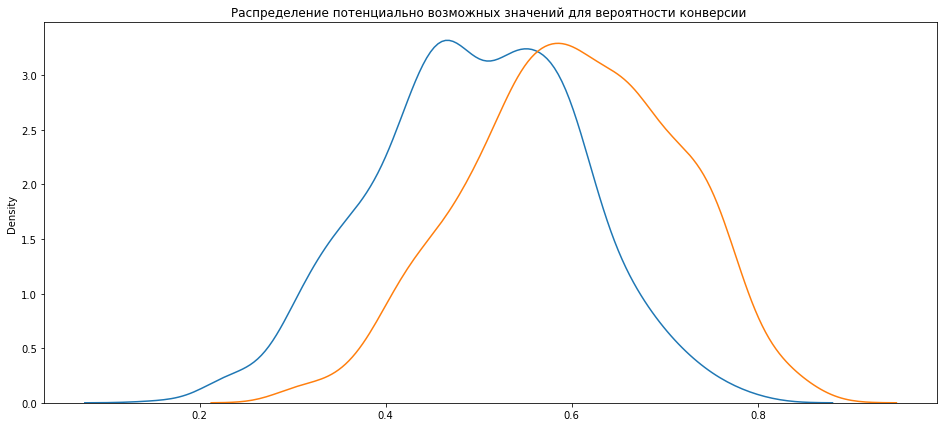

In [2]:
sns.distplot(np.random.beta(10, 10, 1000), kde=True, hist=False);
sns.distplot(np.random.beta(12, 8, 1000), kde=True, hist=False);
plt.title("Распределение потенциально возможных значений для вероятности конверсии ");

# 2. Принцип работы байесовских тестов
Предполагается некое априорное распределения метрик (биномиальные, нормальное,
экспоненциальное и т.д.). Затем, используя полученные данные (новую информацию), мы
пересчитываем распределения для метрик.

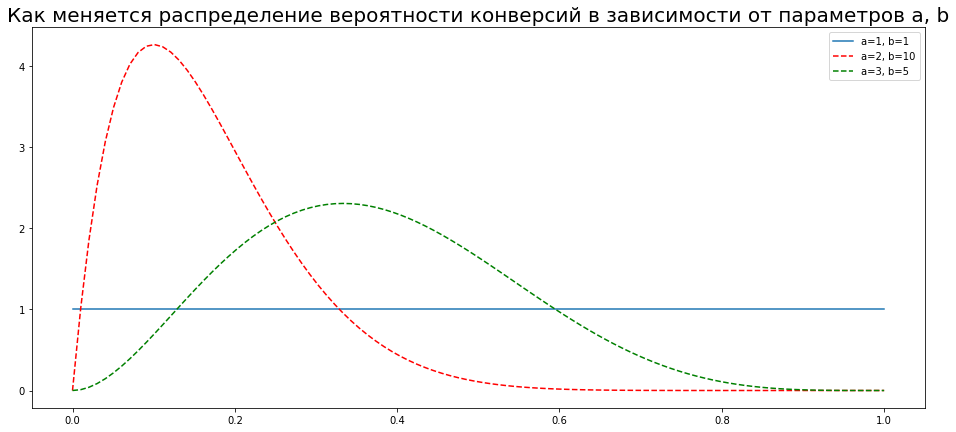

In [19]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 1.0, 100)
y1 = beta.pdf(x, 1, 1)
y2 = beta.pdf(x, 2, 10)
y3 = beta.pdf(x, 3, 5)
plt.plot(x, y1, "-", x, y2, "r--", x, y3, "g--");
plt.legend(['a=1, b=1', 'a=2, b=10', 'a=3, b=5']);
plt.title("Как меняется распределение вероятности конверсий в зависимости от параметров a, b", fontdict={"size": 20});

Рассмотрим пример пересчета плотности распределения конверсий при байесовском AB-тестировании.
Допустим, что на 1 шаге вероятности конверсии у нас одинаковы и равны 0.5. 
Спустя 1 час после эксперимента из 10 пользователей была совершена одна успешная конверсия. Рисунок ниже демонстрирует нам то, как меняется наше априорное распределение о конверсии с учетом новых данных эксперимента.

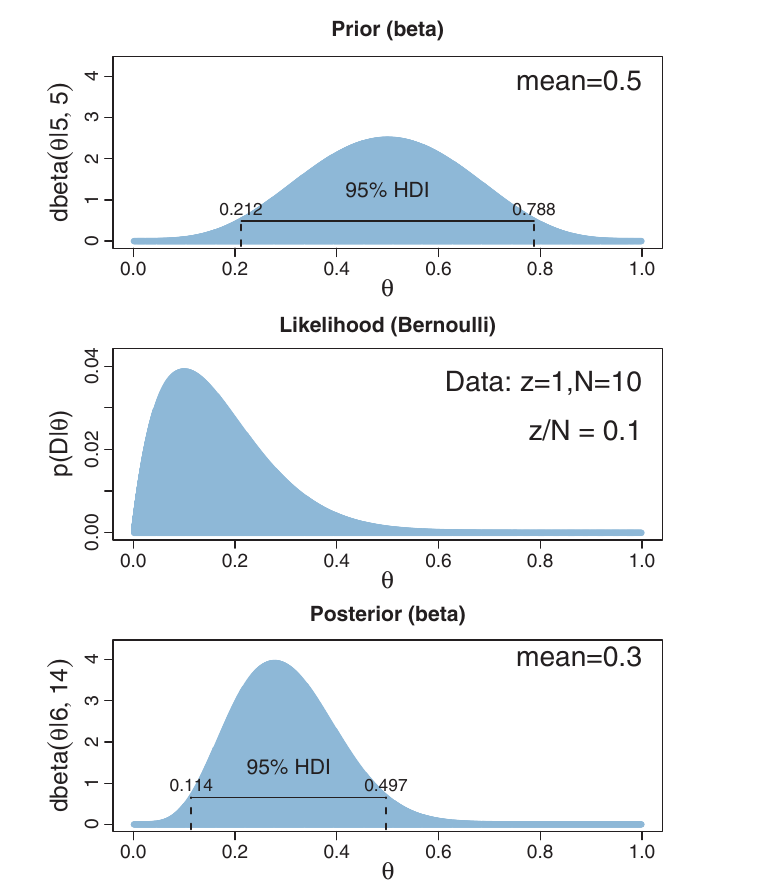

# 3. Основные критерии принятия решений в Байесовских тестах

Основная проблема Байесовских тестов по сравнению с классическими - проблема
контроля ошибки 1 и 2 рода. Особенно это проявляется в случае ранней остановки
алгоритма (когда мы заканчиваем эксперимент при достижении определенных значений
критериев). Ниже будут описаны основные критерии принятия решений
в случае байесовских тестов
(как для алгоритма Томпсона, так и для разбивки 50 на 50).

## 3.1 Вероятность превосходства
Английские термины: *chance to beat control*, *probability superiority*

В случае алгоритма на конверсию у нас в качестве априорного распределения берется
биномиальное. Для того чтобы пересчитать апостериорную вероятность для биномиального
распределения, используется сопряженное ему бета-распределение.
Вероятность превосходства  можно посчитать двумя способами: по точной формуле или при помощи генерации
случайных величин из бета-распределения с параметрами на момент пересчета.

Точная формула описана [здесь](https://www.johndcook.com/UTMDABTR-005-05.pdf).

Метод сэмплирования следующий:

1. Сэмплируем значения из бета-распределений с параметрами
на текущий момент (желательно как можно больше значений)
2. Вычисляем разницу между конверсиями для каждого варианта из
этих распределений
3. Смотрим сумму положительных значений для теста
4. Суммируем и делим на число сэмплирований

In [68]:
# Посмотрим на результаты, полученные разными способами
alphas, betas = [10, 20], [100, 200]
print(f"Точная формула: {calc_prob_between(alphas, betas)}")
print(f"Сэмплирование: {chance_to_beat_all(np.array(alphas), np.array(betas))}")

Точная формула: 0.5148327134707491
Сэмплирование: [0.484711 0.514949]


Отметим, что сэмплирование приводит примерно к тому же результату, но при большом
количестве генераций случайных распределений (например, 1 млн).

Важный момент, который важно понять - эта вероятность превосходства
верна только для текущего набора наблюдений. Другими словами,
мы не знаем, как все изменится при добавлении других данных.
А вот как раз в случае p-value мы можем предположить, в скольких
случаях выигрышный на данный момент вариант может на самом
деле оказаться проигрышным в будущем.

Экспериментальным путем однако выявлено, что в случае
Байесовских тестов без остановки для контроля ошибок
1,2 рода, вероятности превосходства вполне достаточно.

## 3.2 Ожидаемые потери
Английский термин: *expected losses*

Данный критерий описан в [статье](https://www.chrisstucchio.com/pubs/slides/gilt_bayesian_ab_2015/slides.html#1)
*Chris Stucchio* - разработчика
самого лучшего инструмента для АБ-тестов
*Visual Website Optimizer*.


Ожидаемые потери контрольного / тестового варианта - сколько мы ожидаем в среднем потерь в случае,
если выберем контрольный / тестовый вариант. Считается похожим
образом, как и сэплированная вероятность превосходства:
1. Сэмплируем значения из бета-распределений с параметрами
на текущий момент (желательно как можно больше значений)
2. Вычисляем разницу между конверсиями для каждого варианта из
этих распределений
3. Отрицательной разнице присваиваем 0
4. Суммируем и делим на число сэмплирований

Определяем некий порог и в бой!

## 3.3 Достоверные интервалы
Английский термин: *credible intervals*

Достоверные интервалы являются аналогом доверительных интервалов в случае
классических АБ-тестов. Однако, достоверные интервалы фиксируют
нашу текущую неопределенность о потенциальных значениях параметра и
могут быть интерпретированы как вероятностное утверждение о параметре.

Доверительные интервалы отражают неопределенность относительно
полученного нами интервала (т.е. содержит ли он истинное значение или нет).
Таким образом, их нельзя интерпретировать как вероятностное утверждение
об истинных значениях параметров.

Сравним интерпретацию 95% доверительного и достоверного интервала.

В случае доверительного интервала в 95% экспериментах истинное значение
параметра будет лежать в данном диапазоне. Ссылка на объяснение доверительных интервалов: https://www.graphpad.com/guides/prism/7/statistics/stat_more_about_confidence_interval.htm?toc=0&printWindow

В случае достоверного интервала 95% ВСЕХ ЗНАЧЕНИЙ лежит в этом диапазоне.



## 3.4 Размер эффекта
Английский термин: *effect size*

Размер эффект дополняет показатель разницы конверсий и
рассчитывается по такой формуле:

$
\frac{\hat{p_1} - \hat{p_2}} {
[\hat{p_1} * (1 - \hat{p_1}) * (n_1 - 1) + \hat{p_2} *
(1 - \hat{p_2}) * (n_2 - 1)] /
(n_1 + n_2 - 2)}
$

## 3.5 Область практической эквивалентности
Английский термин: *ROPE - region of practical equivalence*

Данный критерий может помочь принять нулевую гипотезу - случай
отсутствия разницы между разными вариантами теста. Рекомендуемое значение
границ *ROPE* = +- 0.1 для размера эффекта.

Если *credible intervals* полностью лежат внутри ROPE, то
делаем вывод, что разницы нет.

***рисунок с вероятностями, а также подсчитанными значениями критериев для какого-то теста***

# 4. Ранняя остановка теста

# 5. Алгоритм Томпсона для задачи многоруких бандитов

# 6. Пример реализации Байесовских тестов без остановки с разными критериями

Будем пользоваться пакетом abyes и собственными вычислениями
В этом пакете мы можем выбрать несколько критериев:
- decision_var = ['es' - effect size; 'lift' - разница эффектов]
- rule = ['loss', 'rope']

Возьмем конверсии со средними по размеру значениями и существенным улучшением: 22% (контрольный вариант)
против 25% (тестовый вариант). - 14% улучшение

In [71]:
n_obs_classic = get_size_zratio(22, 14, 0.05, 0.2)
print(f"Нужно наблюдений для классического теста: {n_obs_classic}")
print(f"Попробуем провести Байесовский тест с: {n_obs_classic / 2}")


Нужно наблюдений для классического теста: 2974
Попробуем провести Байесовский тест с: 1487.0


***Критерий 1:*** ожидаемые потери при выборе контрольного варианта = 2%. (Чем они больше, тем выше вероятность, что тестовый вариант лучше)


*** abyes ***

Method = analytic
Decision Rule = loss
Threshold of Caring = 0.02
Decision Variable = lift

Result is conclusive: B variant is winner!



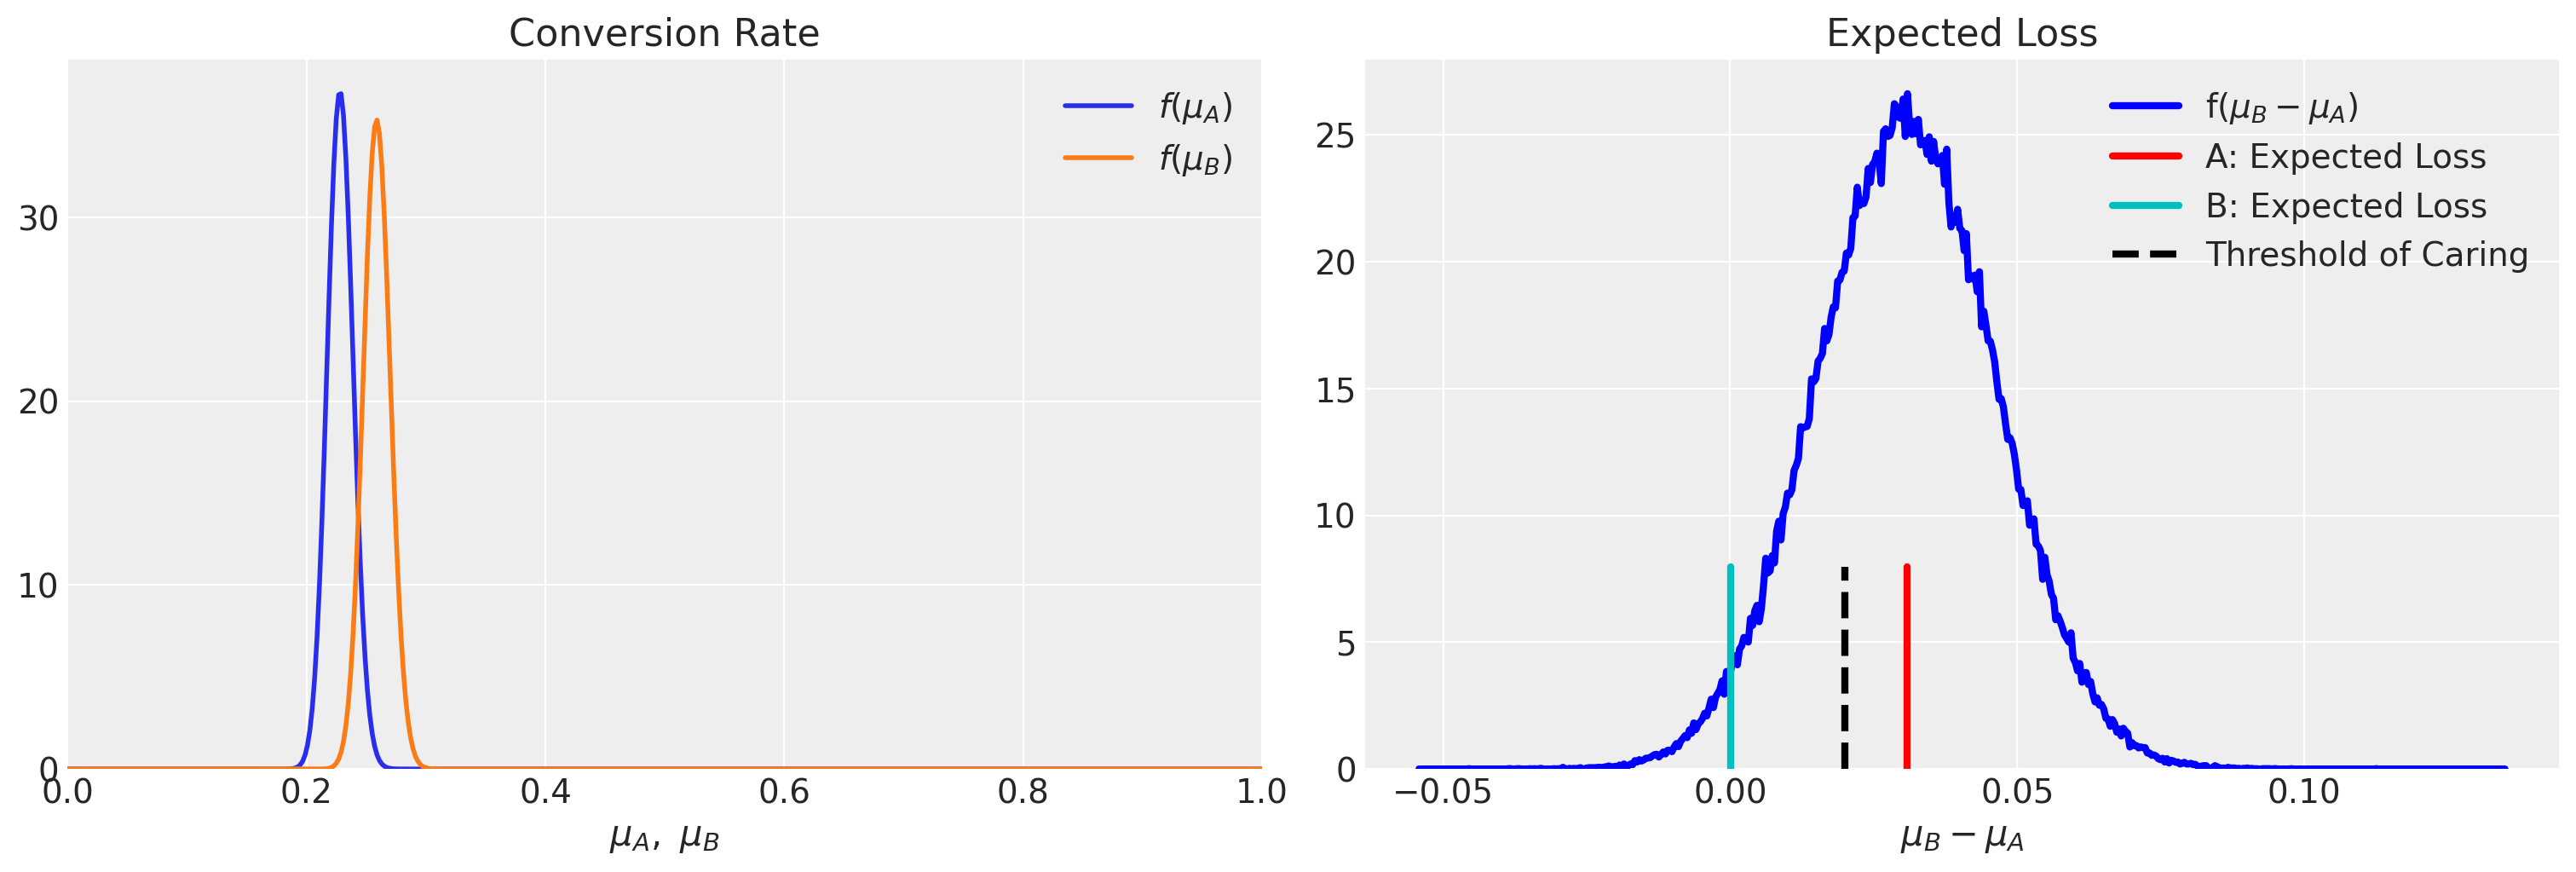

1

In [79]:
import abyes as ab
np.random.seed(0)
data = np.random.binomial([1, 1], [0.22, 0.25], size=(1500, 2))

exp = ab.AbExp(method='analytic', decision_var = 'lift',
               rule='loss', toc=0.02, alpha=0.95, plot=True)
exp.experiment(data.T)

In [73]:
print(f"Значения конверсий на текущий момент: {data.mean(axis=0)}")

Значения конверсий на текущий момент: [0.228      0.25866667]


Попробуем ***второй критерий*** - lift + ROPE.


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.05, 0.05)
Decision Variable = lift

Result is inconclusive.



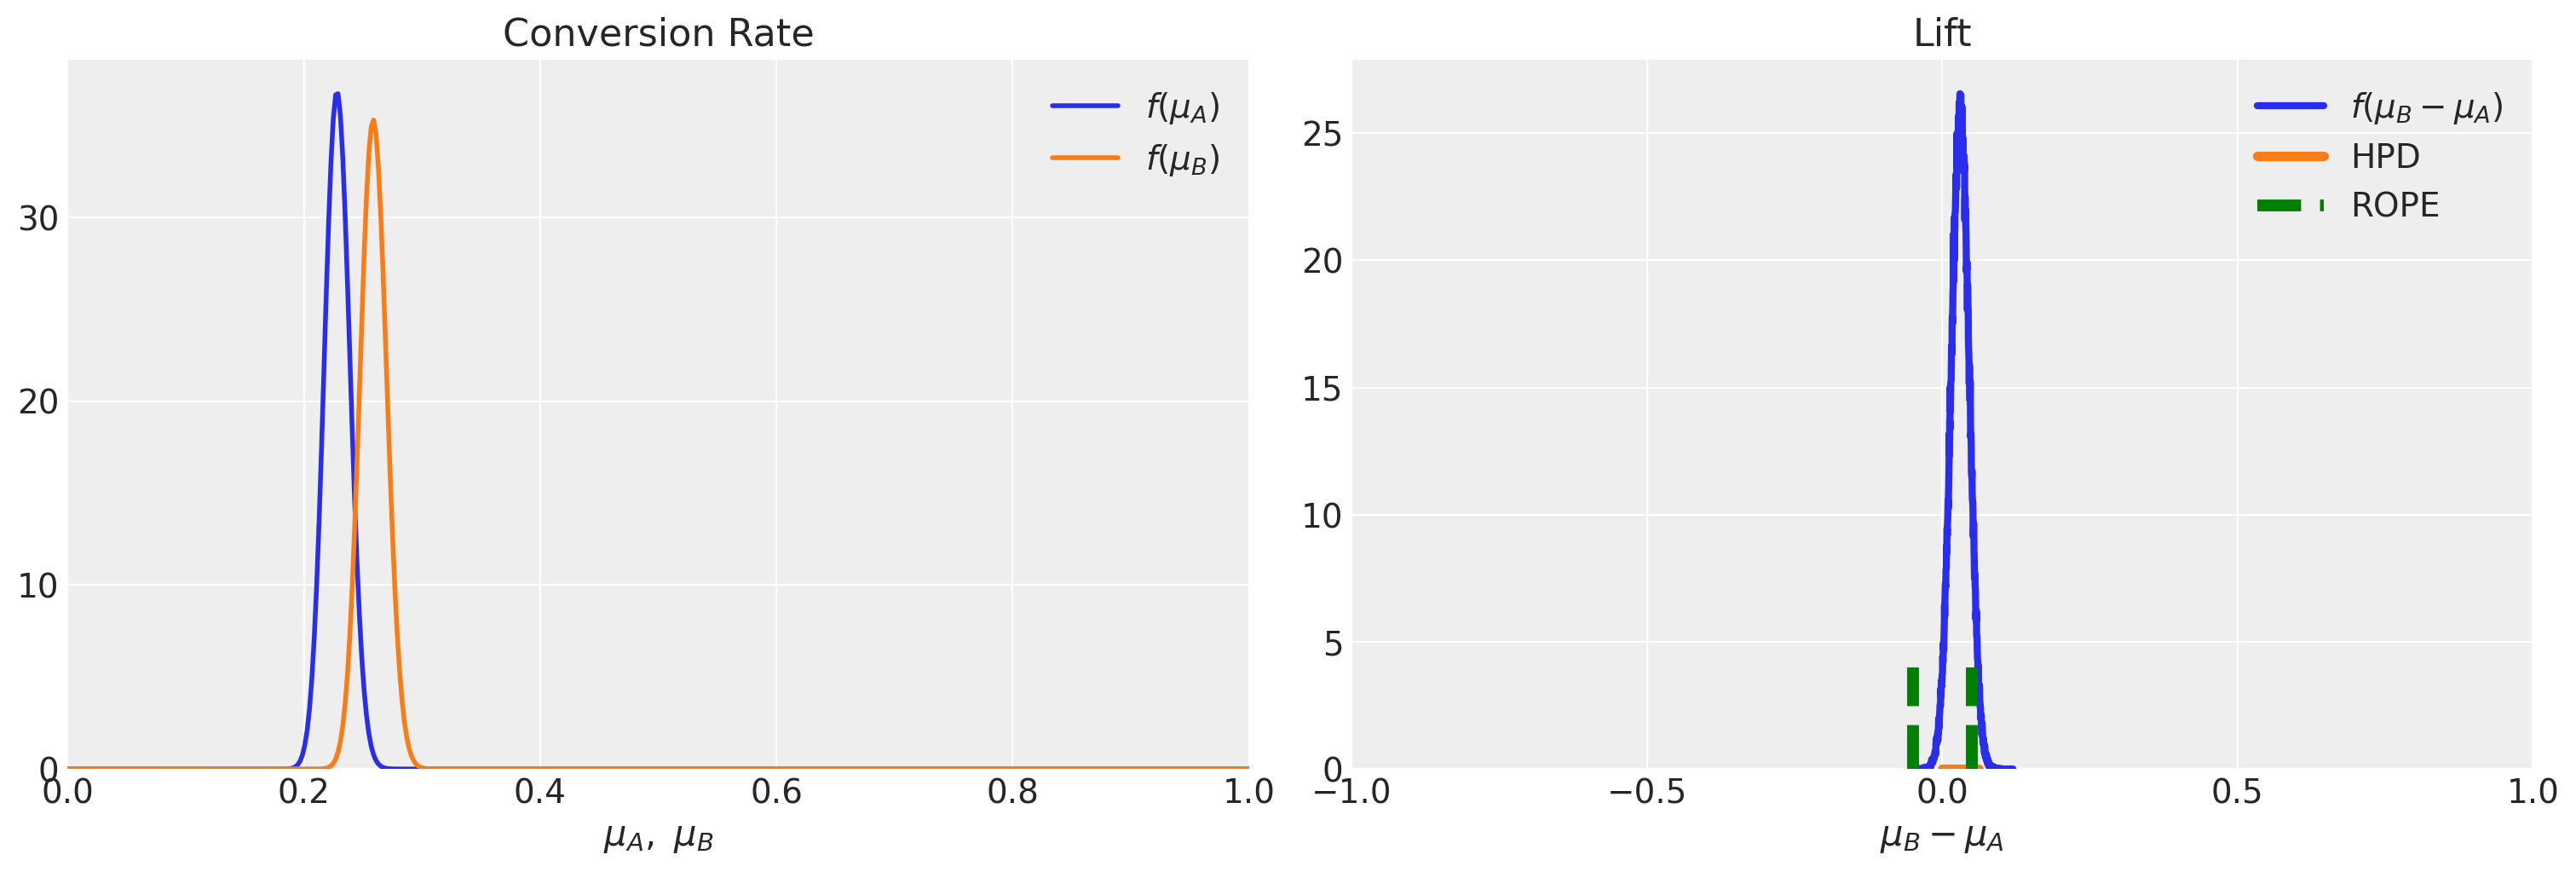

In [74]:
exp = ab.AbExp(method='analytic', decision_var = 'lift',
               rule='rope', rope=(-0.05,0.05), alpha=0.95, plot=True)
results = exp.experiment(data.T)

По этому критерию у нас недостаточно данных, чтобы принять решение. Вероятно, что
мы выбрали неправильный порог для ROPE.

Попробуем ***третий критерий*** - effect size + ROPE


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.01, 0.01)
Decision Variable = es

Result is inconclusive.



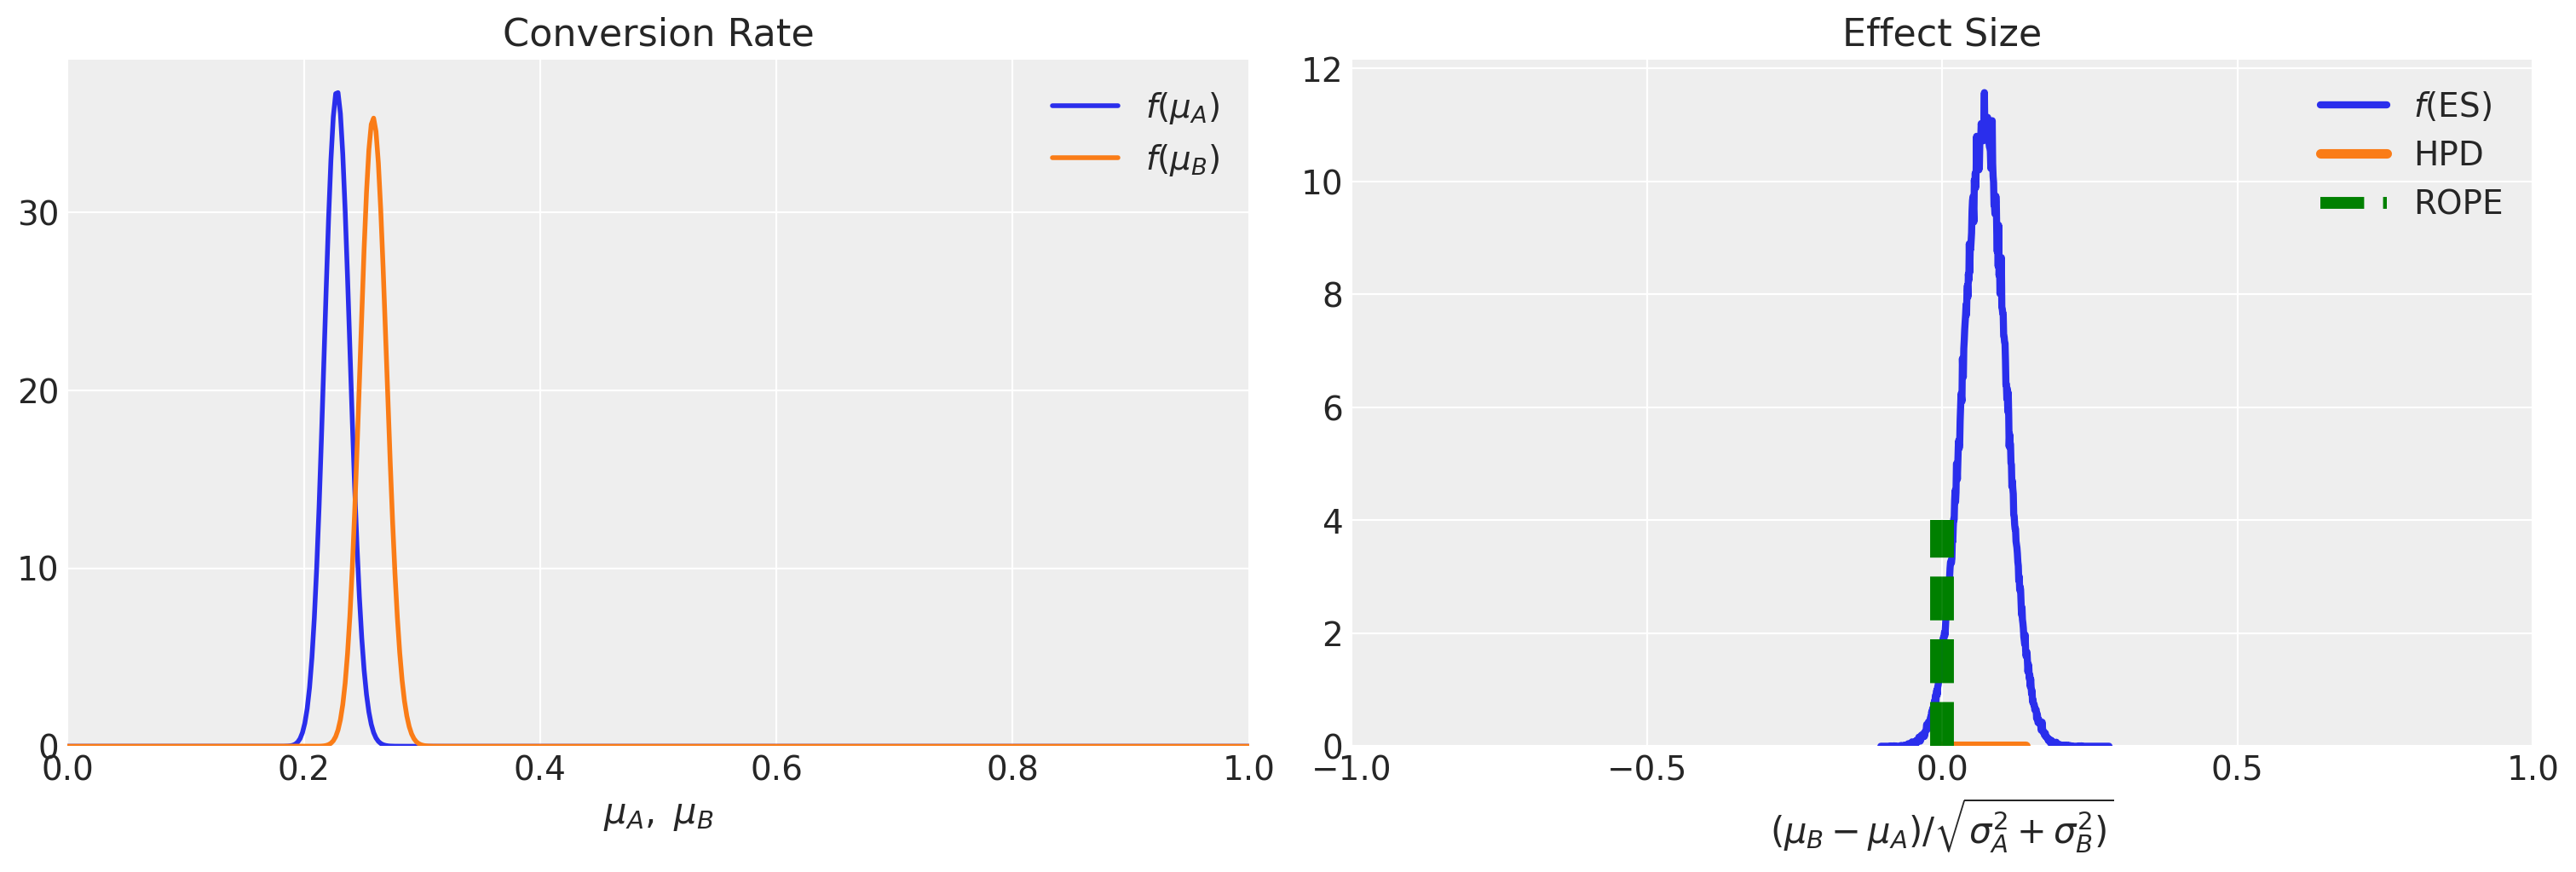

nan

In [75]:
exp = ab.AbExp(method='analytic', decision_var = 'es',
               rule='rope', rope=(-0.01, 0.01), alpha=0.95, plot=True)
exp.experiment(data.T)

Опять не можем принять решение о победителе. Вероятно и тут диапазон для ROPE не очень удачный.
Вычислим теперь все показатели самостоятельно.

In [80]:
alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
ctbc, expected_losses, ctba, results_df = bayesian_metrics(alphas, betas)
print(f"Вероятность превосходства над контрольным вариантом: {ctbc}")
print(f"Ожидаемые потери: {np.round(expected_losses, 5)}")
print(f"95% достоверные интервалы для разницы средних конверсий: {np.round(results_df['HDI_lift'].values[0], 5)}")
results_df

Вероятность превосходства над контрольным вариантом: [0.024963 0.974992]
Ожидаемые потери: [0.03085 0.00015]
95% достоверные интервалы для разницы средних конверсий: [-0.22666 -0.00327]


,,n1,n2,mu1,mu2,var1,var2,effect_size,HDI_lift
var1,var2,,,,,,,,
0,1,1500,1500,0.228,0.258667,0.176016,0.191758,-0.071514,"[-0.2266576736420023, -0.003272367331764947]"


Видим, что 95% достоверный интервал задевает нулевое значение. Давайте попробуем добавить пользователей и пересчитать все показатели.

### Число юзеров = 1750

In [96]:
np.random.seed(0)
data = np.random.binomial([1, 1], [0.22, 0.25], size=(1750, 2))
alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
ctbc, expected_losses, ctba, results_df = bayesian_metrics(alphas, betas)
print(f"Вероятность превосходства над контрольным вариантом: {ctbc}")
print(f"Ожидаемые потери: {np.round(expected_losses, 5)}")
print(f"95% достоверные интервалы для разницы средних конверсий: {np.round(results_df['HDI_lift'].values[0], 5)}")
results_df

Вероятность превосходства над контрольным вариантом: [0.041463 0.958424]
Ожидаемые потери: [0.02539 0.00024]
95% достоверные интервалы для разницы средних конверсий: [-0.19947  0.01109]


,,n1,n2,mu1,mu2,var1,var2,effect_size,HDI_lift
var1,var2,,,,,,,,
0,1,1750,1750,0.231429,0.256571,0.177869,0.190743,-0.058566,"[-0.19947094561735423, 0.011088289608642166]"


Видим, что достоверные интервалы снова включают нулевое значение, а значит принять решение о победителе все еще опасно.
Давайте добавим еще пользователей.

### Число юзеров = 2000

In [83]:
np.random.seed(0)
data = np.random.binomial([1, 1], [0.22, 0.25], size=(2000, 2))
alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
ctbc, expected_losses, ctba, results_df = bayesian_metrics(alphas, betas)
print(f"Вероятность превосходства над контрольным вариантом: {ctbc}")
print(f"Ожидаемые потери: {np.round(expected_losses, 5)}")
print(f"95% достоверные интервалы для разницы средних конверсий: {np.round(results_df['HDI_lift'].values[0], 5)}")
results_df

Вероятность превосходства над контрольным вариантом: [0.007042 0.992999]
Ожидаемые потери: [3.305e-02 3.000e-05]
95% достоверные интервалы для разницы средних конверсий: [-0.22572 -0.03152]


,,n1,n2,mu1,mu2,var1,var2,effect_size,HDI_lift
var1,var2,,,,,,,,
0,1,2000,2000,0.221,0.254,0.172159,0.189484,-0.077605,"[-0.22572247903134146, -0.03152450291074682]"


Видим, что достоверные интервалы теперь уверенно не включают нулевое значение.
Также заметим, что с  добавлением числа новых пользователей достоверные интервалы сначала расширились и включили в себя нулевое значение,
а потом снова сузились.

На этом примере можно наглядно увидеть, что критерии принятия решений довольно нестабильны во времени,
из-за чего процесс остановки теста может быть опасен.

Давайте сгенерируем 1000 случайных рядов с одинаковым математическим ожиданием и посмотрим, в каком % случаев
мы правильно выберем победителя. Собственно это и будет называться нашим экспериментом!

### Число юзеров = 1500

Количество правильно проведенных тестов с критерием превосходства в 0.95: 618


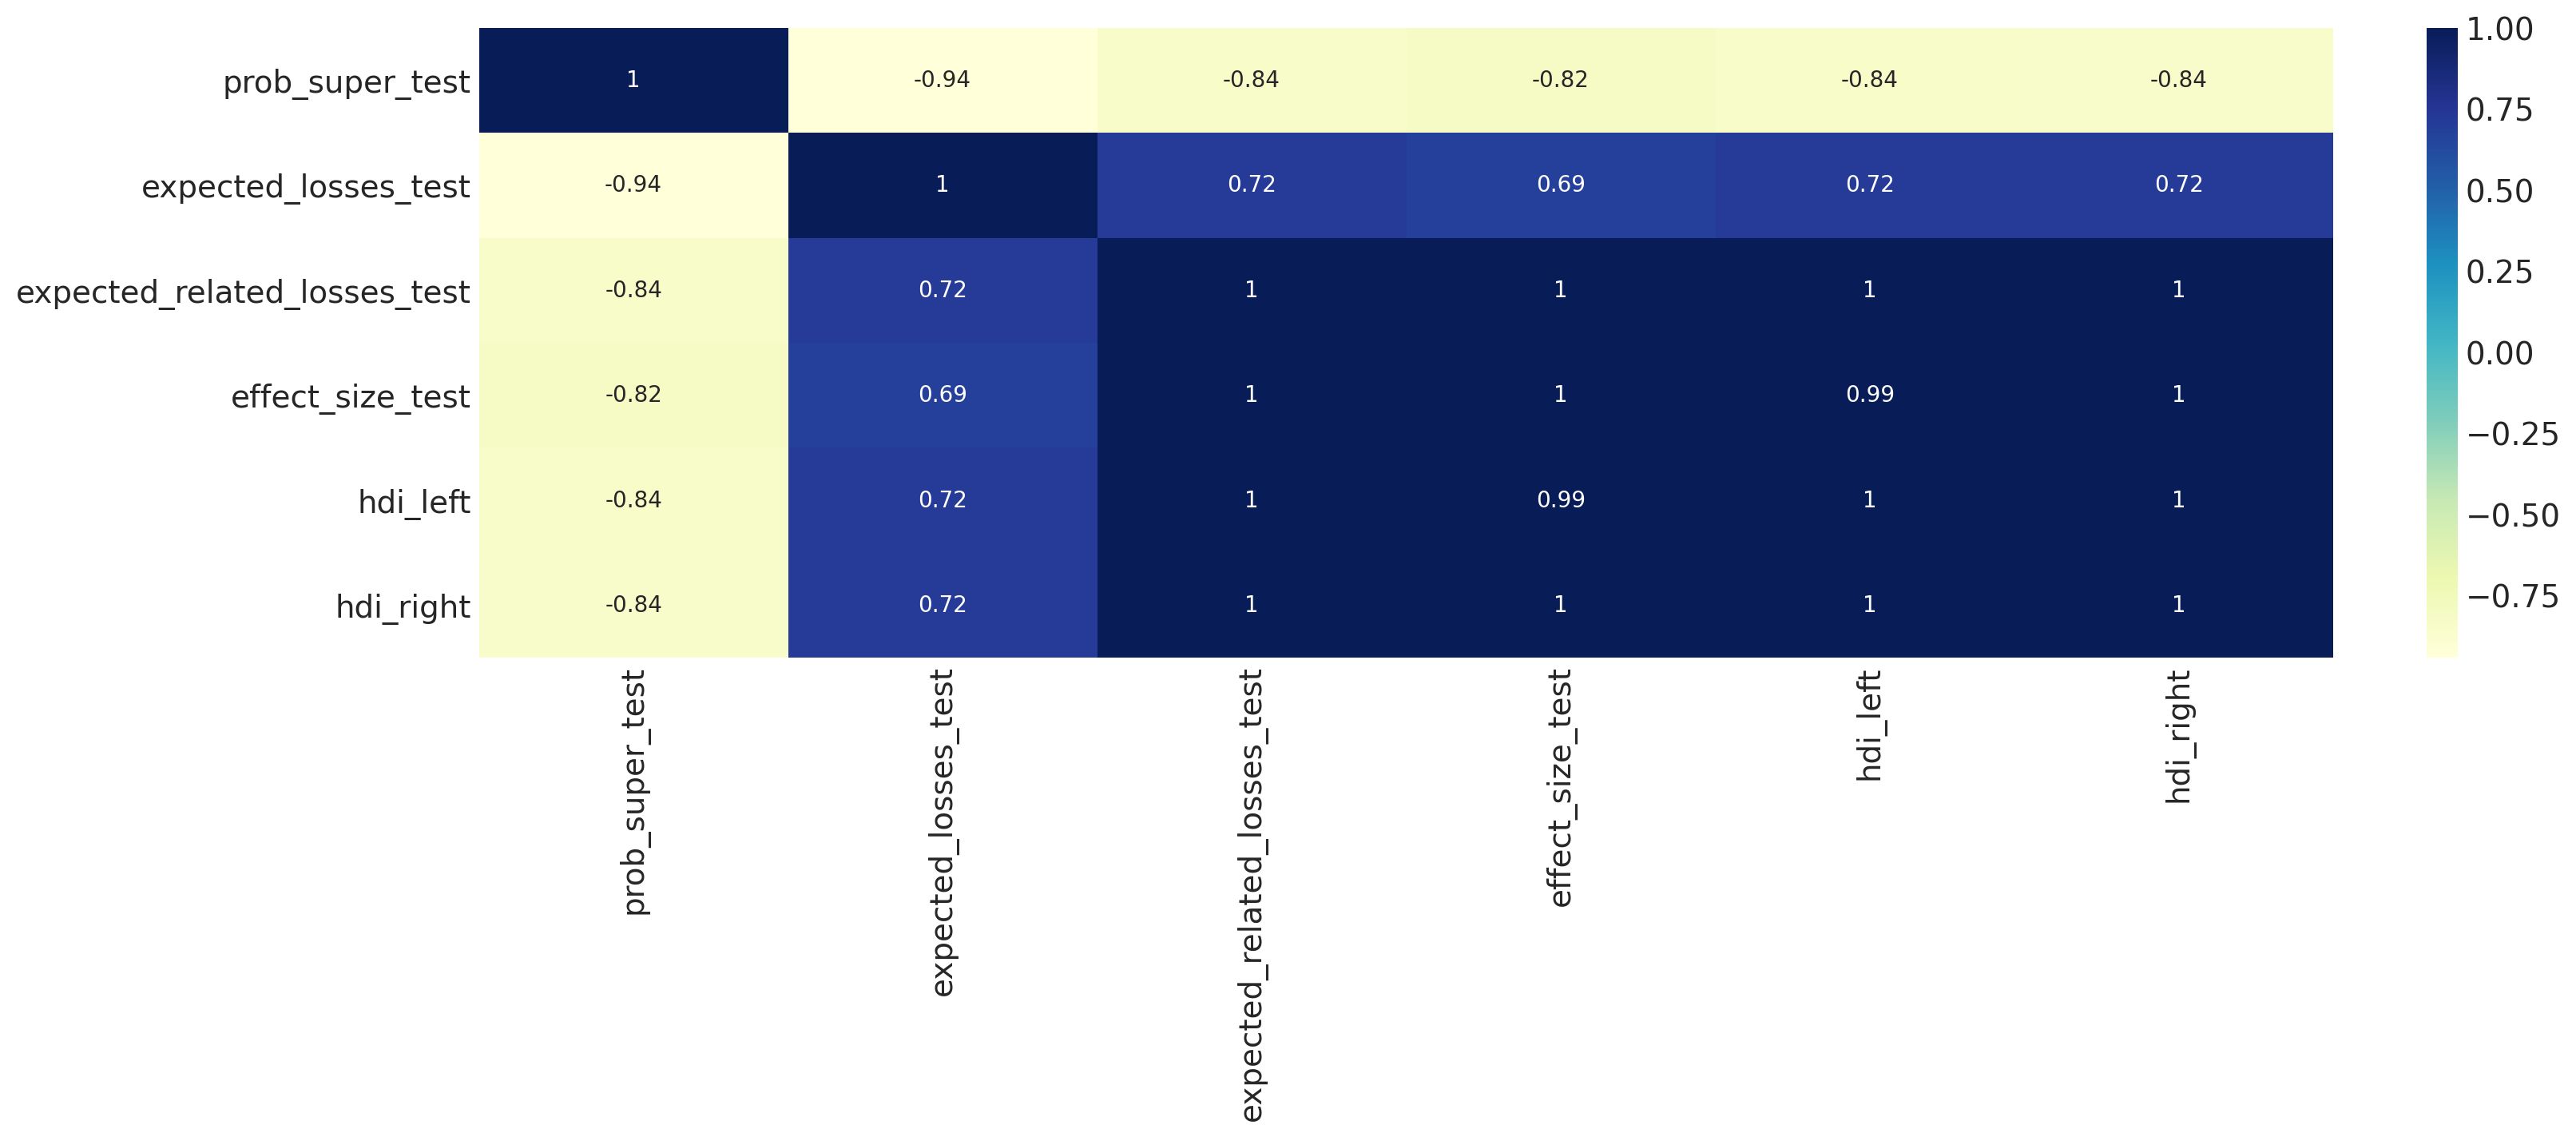

In [99]:
# results = list(p_map(partial(get_bayes_metrics, size=1500), range(1000)))
df = pd.DataFrame(results)
df.columns = ['prob_super_test', 'expected_losses_test', 'expected_related_losses_test',
              'effect_size_test', 'hdi_left', 'hdi_right']
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);
n_correct_tests = df.query("prob_super_test >= 0.95").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 0.95: {n_correct_tests}")

Идентичные пары критериев:
- chance to beat control и expected loss (0.94 корреляция)
- expected related losses и effect size (0.99 корреляция)
- HDI и effect size (0.99 корреляция)
- expected related losses и HDI (0.99 корреляция)

In [104]:
# Давайте снизим порог для вероятности превосходства до 90%
n_correct_tests = df.query("prob_super_test >= 0.9").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 0.9: {n_correct_tests}")

Количество правильно проведенных тестов с критерием превосходства в 0.9: 747


### Число юзеров = 2000

  0%|          | 0/1000 [00:00<?, ?it/s]

Количество правильно проведенных тестов с критерием превосходства в 0.95: 722


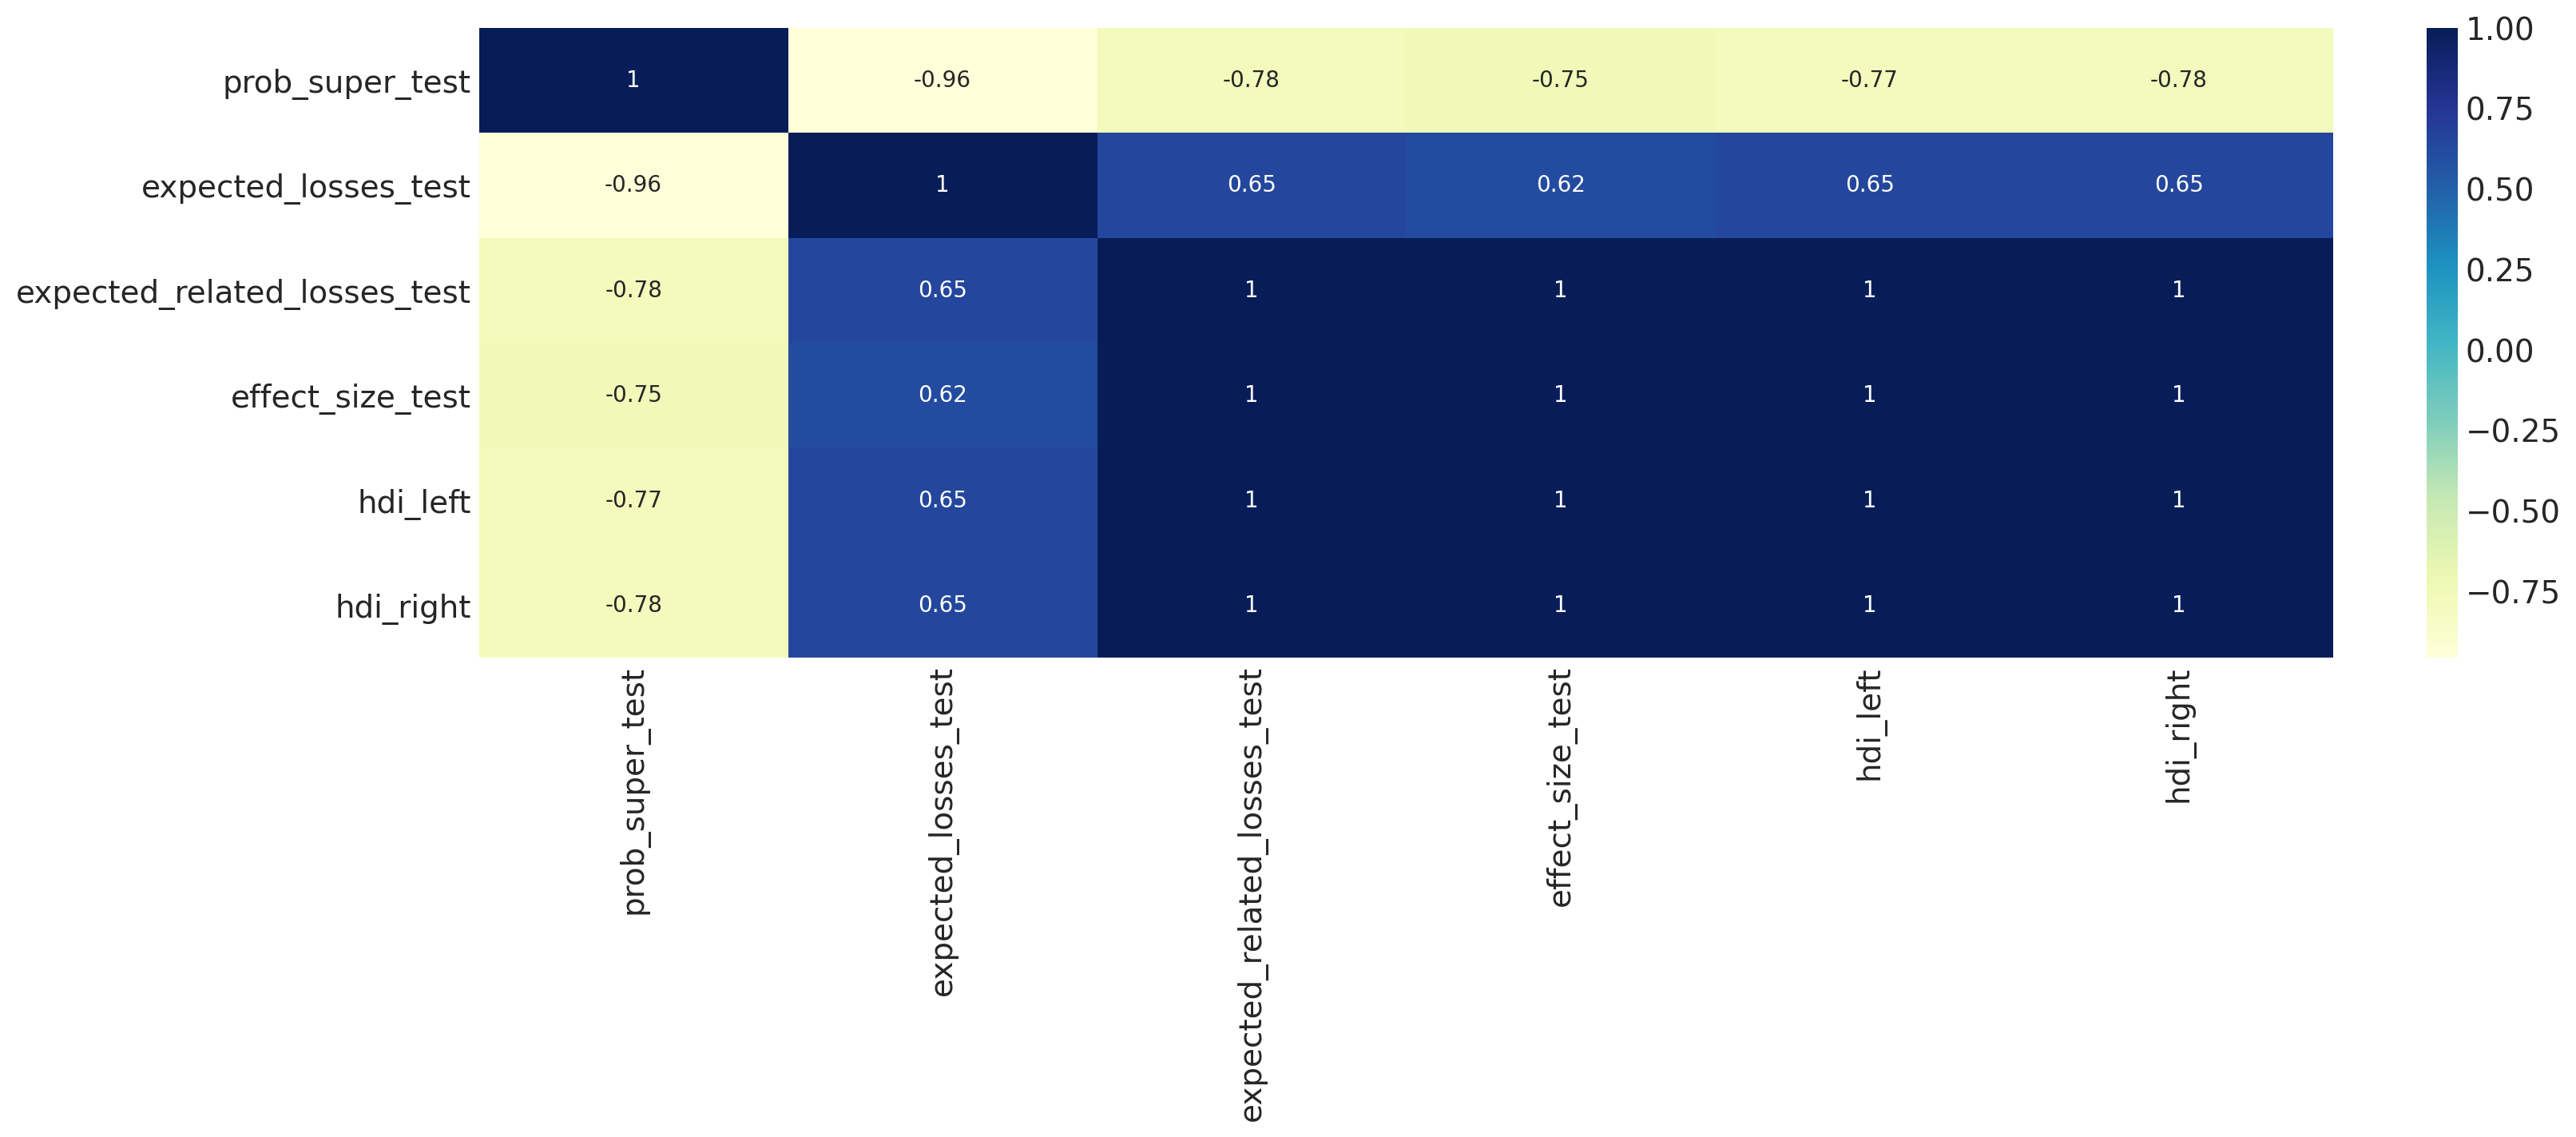

In [105]:
results = list(p_map(partial(get_bayes_metrics, p1=0.22, p2=0.25, size=2000), range(1000)))
df = pd.DataFrame(results)
df.columns = ['prob_super_test', 'expected_losses_test', 'expected_related_losses_test',
              'effect_size_test', 'hdi_left', 'hdi_right']
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);
n_correct_tests = df.query("prob_super_test >= 0.95").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 0.95: {n_correct_tests}")

In [110]:
n_correct_tests = df.query("prob_super_test >= 0.9").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 0.9: {n_correct_tests}")

Количество правильно проведенных тестов с критерием превосходства в 0.9: 837


Казалось бы, давайте снижать порог для вероятности превосходства и дело в шляпе!
Но не тут-то было!
Теперь давайте проведем AA-тесты. Теперь мы будем генерировать выборки с одним и тем же математическим ожиданием.


  0%|          | 0/1000 [00:00<?, ?it/s]

Количество правильно проведенных тестов с критерием превосходства в 80%: 797


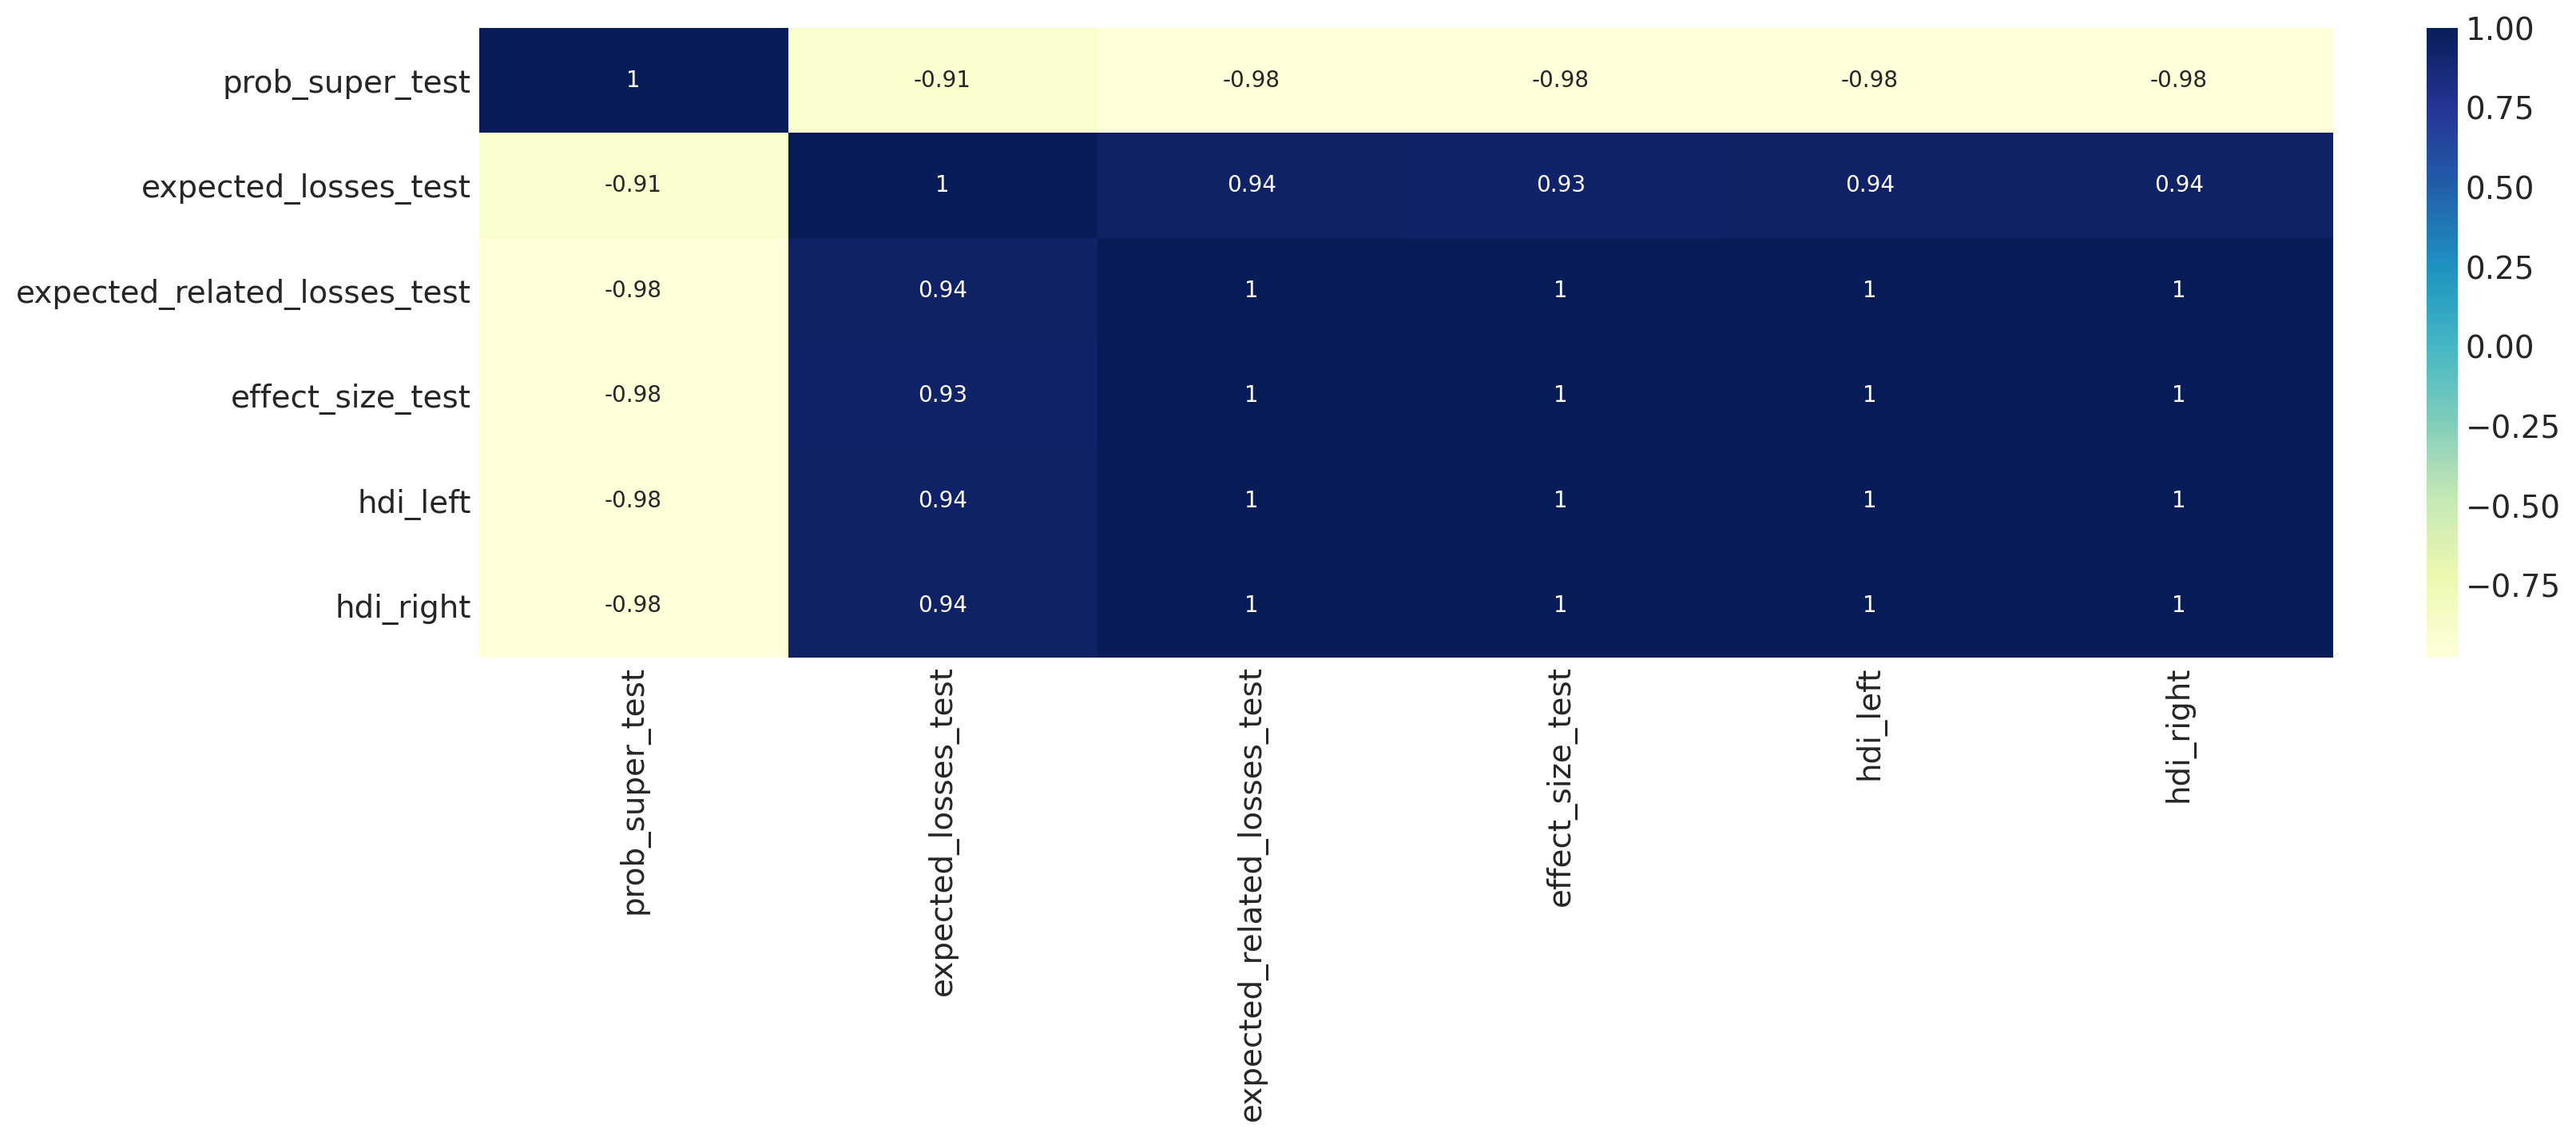

In [111]:
results = list(p_map(partial(get_bayes_metrics, p1=0.22, p2=0.22, size=2000), range(1000)))
df = pd.DataFrame(results)
df.columns = ['prob_super_test', 'expected_losses_test', 'expected_related_losses_test',
              'effect_size_test', 'hdi_left', 'hdi_right']
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);
n_correct_tests = df.query("prob_super_test <= 0.8").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 80%: {n_correct_tests}")

Как мы видим, AA тест показал 20% ошибку 1 рода - мы обнаружили эффект там, где его на самом деле нет.

Давайте теперь сгенерируем ряды с одинаковым математическим ожиданием и проверим гипотезу при помощи готового пакета PyMC3

Running on PyMC3 v3.11.4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 25 seconds.


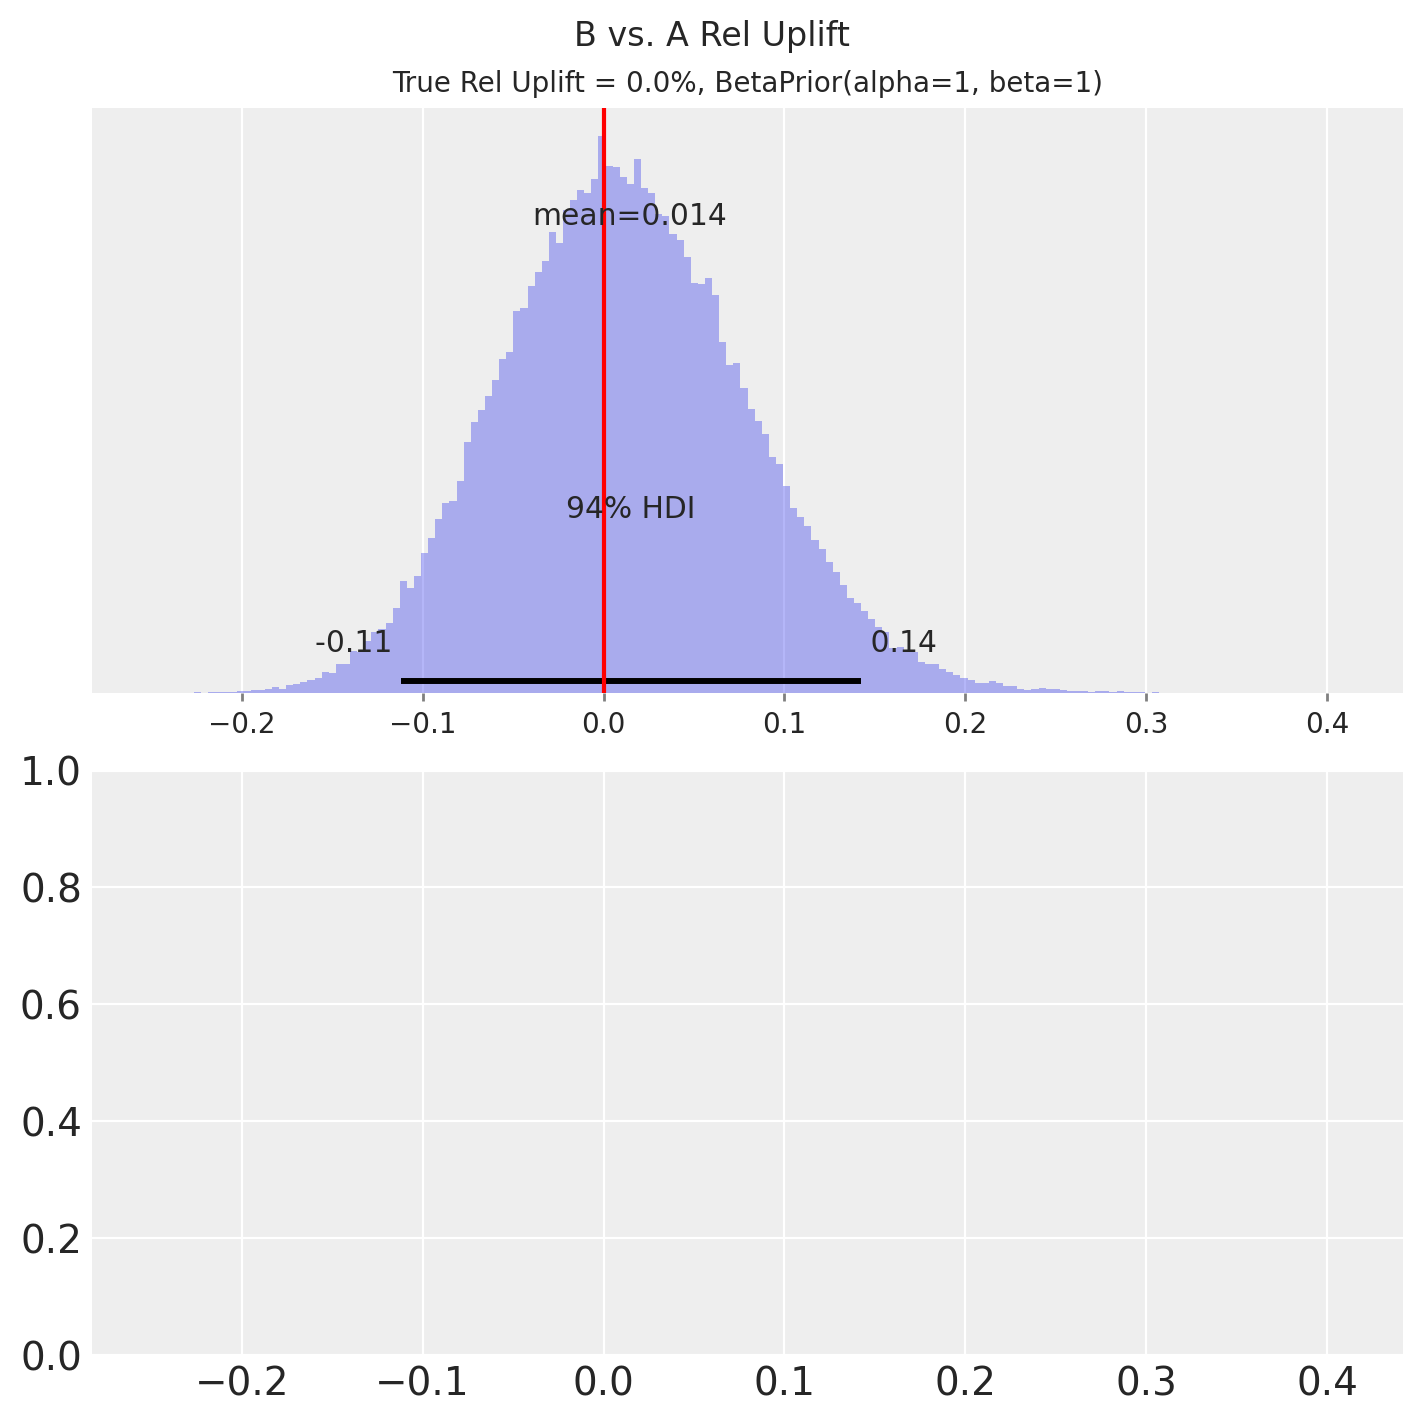

In [113]:
print(f"Running on PyMC3 v{pm.__version__}")
%config InlineBackend.figure_format = 'retina'

az.style.use("arviz-darkgrid")
data_pymc3 = run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.22, 0.22],
    samples_per_variant=1500,
    our_prior=BetaPrior(alpha=1, beta=1)
    # weak_prior=BetaPrior(alpha=100, beta=100),
    # strong_prior=BetaPrior(alpha=10000, beta=10000),
)

# 7. Пример байесовского теста на конверсию с ранней остановкой

Теперь воспользуемся другим пакетом и смоделируем тестирование с остановкой при наступлении определенных критериев.
Установим минимальное число юзеров, когда нельзя останавливать тест, равное 1500.
Предположим, что ежедневно к нам будет поступать порядка 200 пользователей в каждый вариант.

In [150]:
# CPRIOR package for conversion rates
from scipy import stats
e = bayes_conversion_stop_experiment(
                             min_n_samples=1500, max_n_samples=3000,
                             p1=0.22, p2=0.25,
                             criterion="probability_vs_all", criterion_value=0.95, seed=0)
print(e.winner)

B


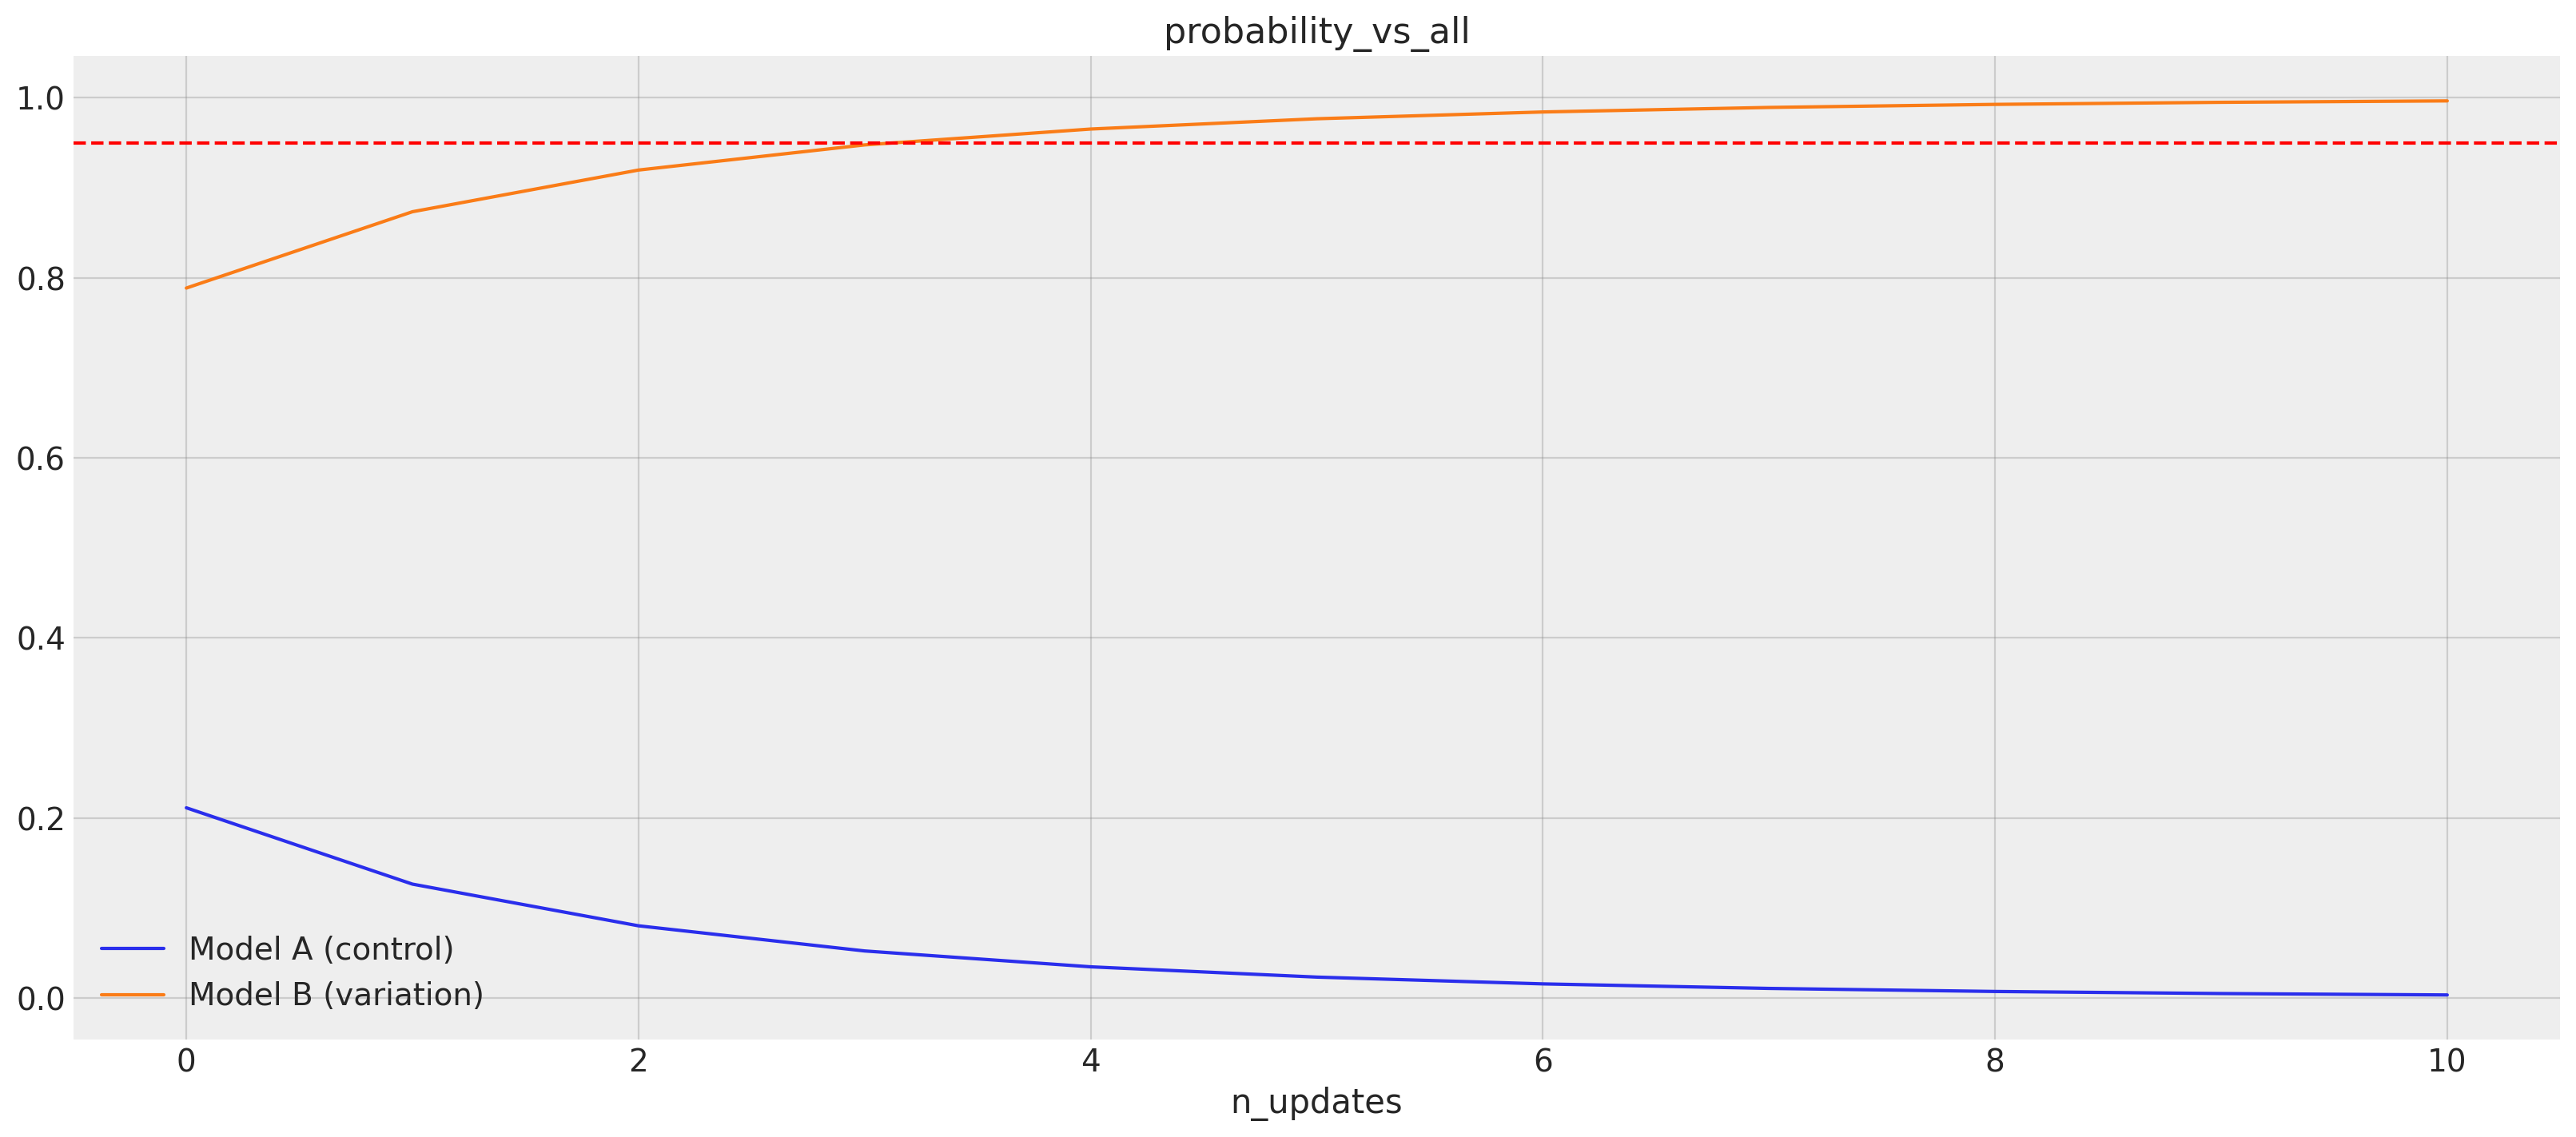

In [151]:
e.plot_metric()

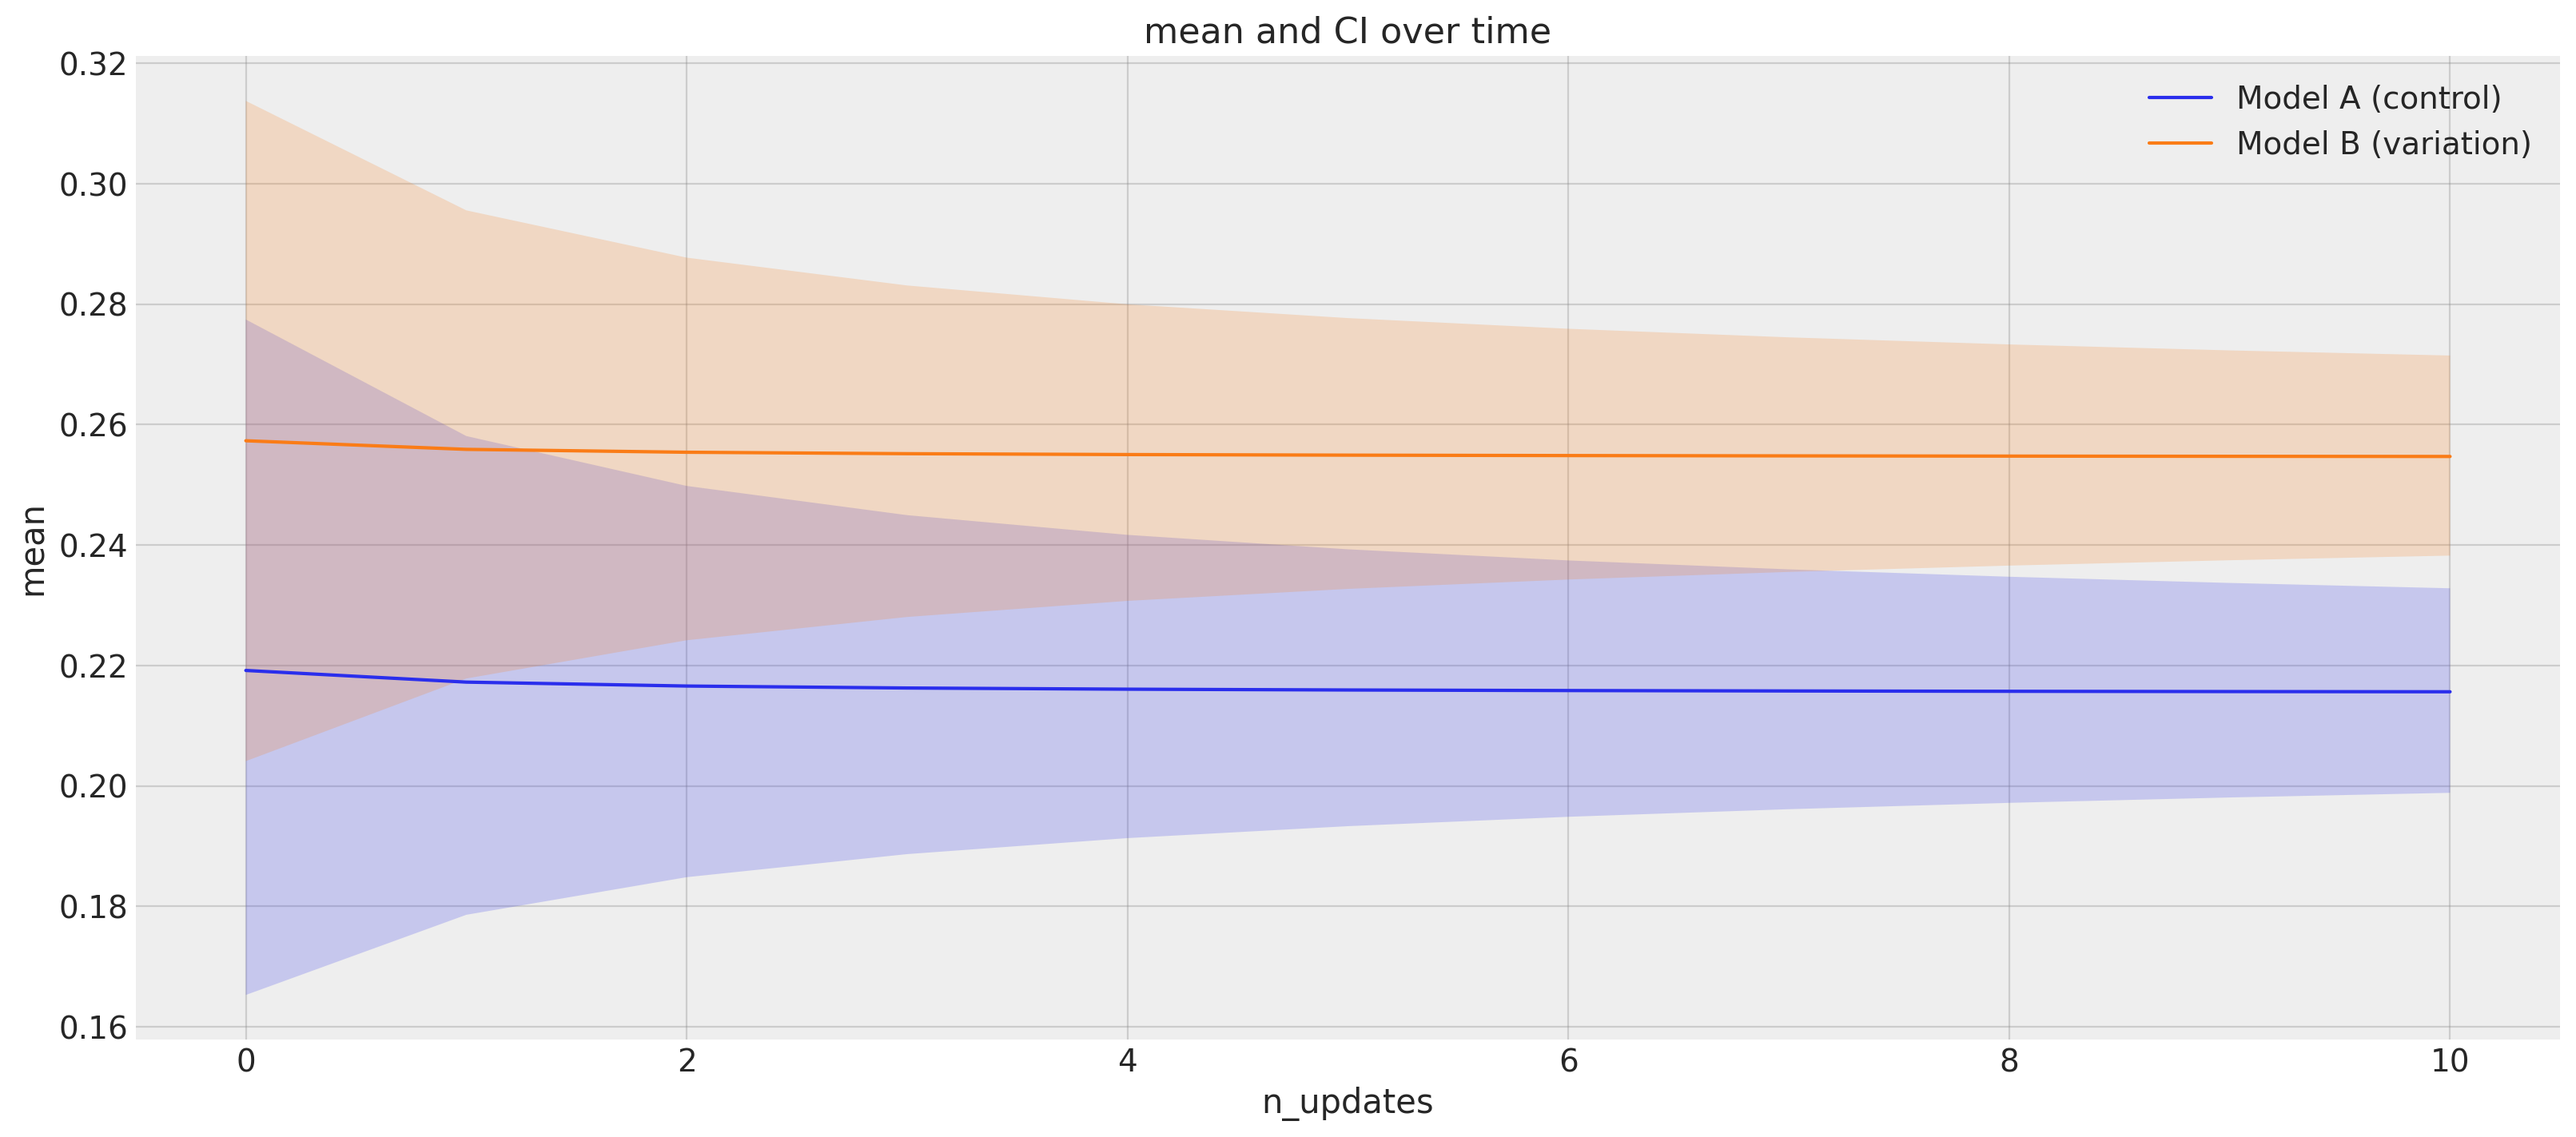

In [152]:
e.plot_stats()

На первый взгляд кажется, что все отлично и никаких проблем при выборе победителя для теста с остановкой быть не должно.
Однако, давайте запустим 1000 экспериментов и посмотрим на долю верно определенных победителей.

In [153]:
results = list(p_map(partial(bayes_conversion_stop_experiment,
                             1500, 3000,
                             0.22, 0.25,
                             "probability_vs_all", 0.95), range(1000)))
from collections import Counter
Counter([i.winner for i in results])

  0%|          | 0/1000 [00:00<?, ?it/s]

Counter({'B': 595, None: 246, 'A': 159})

Видим, что только для 60% всех тестов мы верно выбрали победителя при пороге вероятности превосходства в 95%.

In [154]:
results = list(p_map(partial(bayes_conversion_stop_experiment,
                             1500, 3000,
                             0.22, 0.25,
                             "probability_vs_all", 0.9), range(1000)))
from collections import Counter
Counter([i.winner for i in results])

  0%|          | 0/1000 [00:00<?, ?it/s]

Counter({'B': 622, 'A': 181, None: 197})

In [156]:
results = list(p_map(partial(bayes_conversion_stop_experiment,
                             1500, 3000,
                             0.22, 0.25,
                             "probability_vs_all", 0.95), range(1000)))
from collections import Counter
Counter([i.winner for i in results])

  0%|          | 0/1000 [00:00<?, ?it/s]

Counter({'B': 650, 'A': 192, None: 158})

При снижении порога мощность теста выросла незначительно.

# 8. Пример алгоритма Томпсона на конверсию без ранней остановки

In [126]:
np.random.seed(100)
modelA = BernoulliModel(alpha=1, beta=1)
modelB = BernoulliModel(alpha=1, beta=1)

test = BernoulliABTest(modelA=modelA, modelB=modelB)
test.update_A([0, 1])

test.update_B([0, 1])
batch_size = 10
p_control_percent, mde_percent = 2, 0
n_obs_every_arm = get_size_zratio(p_control_percent, mde_percent, alpha=0.05, beta=0.2)
p1, mde_test = p_control_percent / 100, -(p_control_percent * mde_percent) / 10000
p2 = p1 - mde_test
probability_superiority_step_list = []  # how share of traffic changes across experiment
observations_step_list = np.array([0, 0])  # how many observations is cumulated in every step
expected_loss_step_list = []
alphas_step_list, betas_step_list = np.array([0, 0]), np.array([0, 0])
criterion_stop = (test.probability(variant="A") < 0.95) & (test.probability(variant="B") < 0.95) &\
                 (test.expected_loss_ci(variant="A")[0] < 0 < test.expected_loss_ci(variant="A")[1]) &\
                 (np.sum(observations_step_list) < n_obs_every_arm * 3)
while criterion_stop:
    probability_superiority_step_list.append(test.probability(variant="B"))
    data_A_size = int(batch_size * test.probability(variant="A"))
    data_B_size = int(batch_size * test.probability(variant="B"))
    data_A = np.random.binomial(n=1, p=p1, size=data_A_size)
    data_B = np.random.binomial(n=1, p=p2, size=data_B_size)
    alphas_step_list += np.array([data_A.sum(), data_B.sum()])
    betas_step_list += np.array([data_A_size - data_A.sum(), data_B_size - data_B.sum()])
    observations_step_list += np.array([data_A_size, data_B_size])
    test.update_A(data_A)
    test.update_B(data_B)
    expected_loss_step_list.append(test.expected_loss(variant="A"))
    criterion_stop = (test.probability(variant="A") < 0.95) & (test.probability(variant="B") < 0.95) &\
                     (test.expected_loss_ci(variant="A")[0] < 0 < test.expected_loss_ci(variant="A")[1]) &\
                     (np.sum(observations_step_list) < n_obs_every_arm * 3)
    print(observations_step_list)

[5 5]
[10 10]
[14 14]
[18 18]
[22 22]
[25 28]
[28 34]
[31 40]
[35 45]
[39 50]
[43 55]
[47 60]
[51 65]
[55 70]
[59 75]
[63 80]
[67 85]
[71 90]
[75 95]
[81 98]
[ 88 100]
[ 95 102]
[101 105]
[107 108]
[113 111]
[119 114]
[125 117]
[131 120]
[137 123]
[143 126]
[148 130]
[153 134]
[158 138]
[163 142]
[168 146]
[173 150]
[178 154]
[183 158]
[188 162]
[193 166]
[198 170]
[203 174]
[208 178]
[213 182]
[218 186]
[223 190]
[228 194]
[233 198]
[238 202]
[243 206]
[248 210]
[253 214]
[259 217]
[265 220]
[271 223]
[277 226]
[283 229]
[289 232]
[296 234]
[303 236]
[310 238]
[317 240]
[323 243]
[329 246]
[335 249]
[341 252]
[347 255]
[353 258]
[359 261]
[365 264]
[371 267]
[377 270]
[383 273]
[389 276]
[395 279]
[401 282]
[407 285]
[414 287]
[421 289]
[428 291]
[435 293]
[442 295]
[449 297]
[456 299]
[463 301]
[470 303]
[477 305]
[484 307]
[491 309]
[498 311]
[505 313]
[512 315]
[519 317]
[526 319]
[533 321]
[540 323]
[547 325]
[555 326]
[563 327]
[571 328]
[579 329]
[587 330]
[594 332]
[601 334]
[6

KeyboardInterrupt: 

In [43]:
# Compute P[A > B] and P[B > A]
print("P[A > B] = {:.4f}".format(e.probability(variant="A")))
print("P[B > A] = {:.4f}".format(e.probability(variant="B")))

# Compute posterior expected loss given a variant
print("E[max(B - A, 0)] = {:.4f}".format(e.expected_loss(variant="A")))
print("E[max(A - B, 0)] = {:.4f}".format(e.expected_loss(variant="B")))

P[A > B] = 0.0170
P[B > A] = 0.9830
E[max(B - A, 0)] = 0.0126
E[max(A - B, 0)] = 0.0000
